<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/blackoilvscomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%%capture
!pip install git+https://github.com/equinor/neqsim-python.git

# Black oil vs. Computational Simulation
The reservoir simulation is used because a real reservoir can only be produced once, but a proper model can be produced under different scenarios to optimize the oil recovery (Dandonna et al., 1992). There are two types of simulation methods in the oil industry:

1.
Black oil model: In this model, oil is treated as a single component with no interaction with the gas or water phases.

2.
Compositional model: In this model the interaction between various hydrocarbon phases should be considered.

https://petrowiki.spe.org/Phase_behavior_in_reservoir_simulation

https://www.tandfonline.com/doi/full/10.1080/10916466.2010.506459

https://onepetro.org/SPEATCE/proceedings/00ATCE/All-00ATCE/SPE-63087-MS/132070


# Black-oil PVT models

https://petrowiki.spe.org/Phase_behavior_in_reservoir_simulation

Black oil models are simplified representations of reservoir fluids used in reservoir simulation. In this approach, the complex mixture of hydrocarbons and other components in the reservoir is grouped into three pseudo-components:

1.  **Stock-tank oil:** Represents the liquid phase that remains at standard surface conditions.
2.  **Separator gas:** Represents the gas phase that separates from the oil at standard surface conditions.
3.  **Water:** Represents the aqueous phase.

These pseudo-components are characterized by their physical properties (such as formation volume factors, solution gas-oil ratios, and viscosities) which are typically provided as tables or correlations as a function of pressure and temperature.

The key assumption in black oil models is that the composition of these pseudo-components remains constant, even as pressure and temperature change within the reservoir. This simplification allows for faster and less computationally expensive simulations compared to compositional models, which explicitly track the behavior of individual components.

Black oil models are generally suitable for simulating reservoirs where the fluid behavior is dominated by the dissolution and liberation of gas from the oil (volumetric reservoirs) and where the phase behavior is relatively simple. They are less accurate for reservoirs with complex phase behavior, such as volatile oil or gas condensate reservoirs, where the composition of the phases changes significantly with pressure and temperature.



# Fundamental Equations for Black Oil PVT Models

Black oil PVT models rely on several fundamental relationships to describe the behavior of the pseudo-components (stock-tank oil, separator gas, and water) as a function of pressure and temperature. These relationships are typically presented as tables or correlations. The key properties and their dependencies are:

1.  **Solution Gas-Oil Ratio ($R_s$)**: The volume of gas (at standard conditions) that dissolves in a unit volume of oil (at stock-tank conditions) at a given reservoir pressure and temperature.
    $$R_s = f(P, T)$$

2.  **Formation Volume Factor of Oil ($B_o$)**: The ratio of the volume of oil at reservoir conditions to its volume at standard stock-tank conditions.
    $$B_o = f(P, T)$$

3.  **Formation Volume Factor of Gas ($B_g$)**: The ratio of the volume of gas at reservoir conditions to its volume at standard stock-tank conditions.
    $$B_g = f(P, T)$$

4.  **Formation Volume Factor of Water ($B_w$)**: The ratio of the volume of water at reservoir conditions to its volume at standard stock-tank conditions.
    $$B_w = f(P, T)$$

5.  **Viscosity of Oil ($\mu_o$)**: The resistance of oil to flow at a given reservoir pressure and temperature.
    $$\mu_o = f(P, T)$$

6.  **Viscosity of Gas ($\mu_g$)**: The resistance of gas to flow at a given reservoir pressure and temperature.
    $$\mu_g = f(P, T)$$

7.  **Viscosity of Water ($\mu_w$)**: The resistance of water to flow at a given reservoir pressure and temperature.
    $$\mu_w = f(P, T)$$

8.  **Density of Oil ($\rho_o$)**: The mass of oil per unit volume at a given reservoir pressure and temperature. In a black oil model, this is often calculated based on the mass conservation of the pseudo-components:
    $$\rho_o(P) = \frac{\rho_{o,sc} + R_s(P) \rho_{g,sc}}{B_o(P)}$$
    where $\rho_{o,sc}$ and $\rho_{g,sc}$ are the densities of stock-tank oil and separator gas at standard conditions, respectively.

9.  **Density of Gas ($\rho_g$)**: The mass of gas per unit volume at a given reservoir pressure and temperature.
    $$\rho_g(P) = \frac{\rho_{g,sc}}{B_g(P)}$$

10. **Density of Water ($\rho_w$)**: The mass of water per unit volume at a given reservoir pressure and temperature.
    $$\rho_w(P) = \frac{\rho_{w,sc}}{B_w(P)}$$

These properties are typically provided as tables for a range of pressures at a constant reservoir temperature. The relationships implicitly account for phase changes (like gas liberation from oil) as pressure changes.

# NeqSim Black-Oil Model

## 1) What is it?

A lightweight **Black-Oil PVT** module that works from either:

- **Direct PVT tables**: $R_s, R_v, B_o, B_g, B_w, \mu_o, \mu_g, \mu_w$ as functions of pressure; or
- An **ECLIPSE deck** (`PVTO/PVTG/PVTW` + `DENSITY`) via an importer.

**Main classes (Java package `neqsim.blackoil`):**
- `BlackOilPVTTable` — pressure-indexed table with linear interpolation
- `BlackOilFlash` — classic Black-Oil flash (phase split + bulk properties)
- `SystemBlackOil` — a stream wrapper carrying P/T and standard totals
- `EclipseBlackOilImporter` — parse ECLIPSE PVT → `BlackOilPVTTable` (+ seeded `SystemBlackOil`)
- `BlackOilConverter` — convert a compositional NeqSim fluid → Black-Oil table (optional)
- `BlackOilSeparator` — simple stage separator at given (P,T)

---

## 2) Assumptions (summary)

- Single **reference temperature** $T_\mathrm{ref}$; PVT functions are $P$-dependent.
- **Linear interpolation** in pressure; **clamp** outside tabulated ranges (configurable).
- **Bubblepoint rule:**
  $$
  R_s(P > P_b) = R_s(P_b)
  $$
- $R_v(P)$ optional (defaults to 0 if not tabulated).
- **Surface densities** $\rho_{o,sc}, \rho_{g,sc}, \rho_{w,sc}$ are constant inputs.
- No energy/enthalpy in this minimal model.

---

## 3) Units & conventions

Use consistent units. The implementation assumes:

- Pressure $P$: **bar** (Pa also ok if consistent)
- Stock-tank volumes: **Sm³**
- Formation volume factors: **rm³/Sm³**
- Viscosities: **Pa·s** (1 cP = $1.0\times10^{-3}$ Pa·s)
- Surface densities: **kg/Sm³** (≈ kg/m³ at std)

The ECLIPSE importer converts **FIELD ↔ METRIC** automatically.

---

## 4) PVT functions at $T_\mathrm{ref}$

For each pressure $P$, the table provides:

- Solution GOR: $R_s(P)$ [Sm³ gas / Sm³ oil]
- Vaporized oil ratio: $R_v(P)$ [Sm³ oil / Sm³ gas]
- Formation volume factors:
  $$
  B_o(P), \quad B_g(P), \quad B_w(P) \quad [\mathrm{rm}^3/\mathrm{Sm}^3]
  $$
- Viscosities:
  $$
  \mu_o(P),\ \mu_g(P),\ \mu_w(P) \quad [\mathrm{Pa}\cdot\mathrm{s}]
  $$

Interpolation is **piecewise linear** in $P$.

---

## 5) Black-Oil flash (phase split & properties)

Given a stream at $(P,T)$ with **standard totals**:
- $O_\mathrm{tot}^{sc}$ — stock-tank oil [Sm³]
- $G_\mathrm{tot}^{sc}$ — stock-tank gas [Sm³]
- $W^{sc}$ — stock-tank water [Sm³]

Let tabulated values at $P$ be $R_s, R_v, B_o, B_g, B_w$.

### 5.1 Stock-tank split

- If **no free gas** fits criterion $G_\mathrm{tot}^{sc} \le R_s O_\mathrm{tot}^{sc}$:
  $$
  G_f^{sc} = 0, \qquad O^{sc} = O_\mathrm{tot}^{sc}
  $$
- Else (free gas present):
  $$
  \begin{aligned}
  D &= 1 - R_s R_v \\
  G_f^{sc} &= \frac{G_\mathrm{tot}^{sc} - R_s O_\mathrm{tot}^{sc}}{\max(D, \varepsilon)} \\
  O^{sc}   &= \max\left(0, O_\mathrm{tot}^{sc} - R_v G_f^{sc}\right)
  \end{aligned}
  $$
with $\varepsilon \sim 10^{-12}$ to avoid division by zero.

### 5.2 Reservoir volumes

$$
V_o = B_o O^{sc}, \qquad
V_g = B_g G_f^{sc}, \qquad
V_w = B_w W^{sc}
$$

### 5.3 Densities (classic Black-Oil)

Let surface densities be $\rho_{o,sc}, \rho_{g,sc}, \rho_{w,sc}$ [kg/Sm³]:
$$
\begin{aligned}
\rho_o(P) &= \frac{\rho_{o,sc} + R_s(P) \rho_{g,sc}}{B_o(P)} \\
\rho_g(P) &= \frac{\rho_{g,sc}}{B_g(P)} \\
\rho_w(P) &= \frac{\rho_{w,sc}}{B_w(P)}
\end{aligned}
$$
Viscosities: $\mu_o(P), \mu_g(P), \mu_w(P)$ direct from table.

---

## 6) Mapping from ECLIPSE PVT

- **`PVTO`**: Each block header is a saturated point $(P, R_s, B_o, \mu_o)$ below $P_b$. The block with **max $R_s$** defines the **undersaturated** branch above $P_b$. The model clamps $R_s(P>P_b)=R_s(P_b)$.
- **`PVTG`**: Use the **$R_v \approx 0$** block for $(P, B_g, \mu_g)$. (Extendable to dew-path $R_v(P)$.)
- **`PVTW`**: Water $(P, B_w, \mu_w)$.
- **`DENSITY`**: Surface densities $\rho_{o,sc}, \rho_{w,sc}, \rho_{g,sc}$.

Outside table ranges, importer **clamps** (you may switch to linear extrapolation with guards).

---

## 7) Minimal usage (Java)

### 7.1 From an ECLIPSE deck
```java
import java.nio.file.Paths;
import neqsim.blackoil.io.EclipseBlackOilImporter;
import neqsim.blackoil.*;

var res = EclipseBlackOilImporter.fromFile(Paths.get("MY_FLUID.DAT"));
BlackOilPVTTable pvt = res.pvt;
SystemBlackOil stream = res.system;             // seeded: 1 Sm3 oil, gas = Rs(Pb)

stream.setStdTotals(1000.0, 500.0, 100.0);      // O_std, G_std, W_std [Sm3]
stream.setPressure(170.0);
stream.setTemperature(350.0);                   // T not used in basic Black-Oil

BlackOilFlashResult r = stream.flash();
System.out.println("rho_g = " + r.rho_g + " kg/m3");
System.out.println("Vo = " + r.V_o + " m3");
```

# NeqSim black oil calclaution example

In [28]:
# Import the root Java package and specific classes
from neqsim import jneqsim as neqsim
import java.util.ArrayList as ArrayList
import numpy as np

# Define aliases for the Java classes for convenience
BlackOilPVTTable = neqsim.blackoil.BlackOilPVTTable
SystemBlackOil = neqsim.blackoil.SystemBlackOil

# Python implementation of the linear interpolation function from the Java test
def lerp(xp, yp, x):
    """Linear interpolation with end clamping."""
    if x <= xp[0]:
        return yp[0]
    for i in range(len(xp) - 1):
        if x <= xp[i + 1]:
            t = (x - xp[i]) / (xp[i + 1] - xp[i])
            return yp[i] * (1.0 - t) + yp[i + 1] * t
    return yp[-1]

# Define the PVT data points as Python lists
boP = np.array([100.0, 200.0, 300.0])
boV = np.array([1.5, 1.4, 1.3])

bgP = np.array([120.0, 150.0, 200.0])
bgV = np.array([0.0045, 0.0042, 0.0040])

bwP = np.array([50.0, 150.0, 250.0])
bwV = np.array([1.02, 1.01, 1.00])

rsP = np.array([0.0, 100.0, 200.0])
rsV = np.array([1.2, 1.15, 1.12])

rvP = np.array([0.0, 150.0, 200.0])
rvV = np.array([0.0045, 0.0042, 0.0040])

# Build a merged pressure grid
pressure_grid = np.array([100.0, 120.0, 150.0, 170.0, 200.0, 250.0, 300.0])

records_list = ArrayList()

# 2. Loop and create Java Record objects, not Python dicts
for p in pressure_grid:
    Bo = lerp(boP, boV, p)
    Bg = lerp(bgP, bgV, p)
    Bw = lerp(bwP, bwV, p)
    Rs = lerp(rsP, rsV, p)
    Rv = lerp(rvP, rvV, p)

    # simple positive viscosities (Pa·s) for the test
    mu_o = 1.5e-3
    mu_g = 1.0e-5
    mu_w = 0.5e-3

    # 3. Instantiate the Java Record class directly
    record = BlackOilPVTTable.Record(p, Rs, Bo, mu_o, Bg, mu_g, Rv, Bw, mu_w)
    records_list.add(record)

# Define the bubble point
bubble_point = 150.0

# The constructor now receives the correct Java types: a java.util.List and a double
pvt_table = BlackOilPVTTable(records_list, bubble_point)
print("Manually created PVT table.")

# Define surface densities
rho_o_sc = 800.0  # kg/Sm3
rho_g_sc = 1.2    # kg/Sm3
rho_w_sc = 1000.0 # kg/Sm3

# Create a SystemBlackOil instance
black_oil_stream = SystemBlackOil(pvt_table, rho_o_sc, rho_g_sc, rho_w_sc)

# Set conditions for the flash calculation
black_oil_stream.setPressure(170.0)  # bar
black_oil_stream.setTemperature(100.0) # °C
black_oil_stream.setStdTotals(1000.0, 500.0, 100.0) # Oil, Gas, Water in Sm3

# Perform the flash calculation
flash_result = black_oil_stream.flash()

# Print and assert results
print("\n--- Flash Results at 170.0 bar (Manual PVT) ---")
print(f"Oil Density (reservoir):      {black_oil_stream.getOilDensity():.2f} kg/m³")
print(f"Gas Density (reservoir):      {black_oil_stream.getGasDensity():.2f} kg/m³")
print(f"Water Density (reservoir):    {black_oil_stream.getWaterDensity():.2f} kg/m³")
print("-" * 35)
print(f"Oil Volume (reservoir):       {black_oil_stream.getOilReservoirVolume():.2f} m³")
print(f"Gas Volume (reservoir):       {black_oil_stream.getGasReservoirVolume():.2f} m³")
print(f"Water Volume (reservoir):     {black_oil_stream.getWaterReservoirVolume():.2f} m³")
print("-" * 35)
print(f"Oil Viscosity:                {black_oil_stream.getOilViscosity() * 1000:.3f} cP")
print(f"Gas Viscosity:                {black_oil_stream.getGasViscosity() * 1000:.3f} cP")
print(f"Water Viscosity:              {black_oil_stream.getWaterViscosity() * 1000:.3f} cP")

# Basic assertions
assert black_oil_stream.getOilDensity() > 0.0, "Oil density should be positive"
assert black_oil_stream.getGasDensity() > 0.0, "Gas density should be positive"

print("\nFlash calculation from manual PVT table finished successfully.")

Manually created PVT table.

--- Flash Results at 170.0 bar (Manual PVT) ---
Oil Density (reservoir):      560.39 kg/m³
Gas Density (reservoir):      291.26 kg/m³
Water Density (reservoir):    992.06 kg/m³
-----------------------------------
Oil Volume (reservoir):       1430.00 m³
Gas Volume (reservoir):       0.00 m³
Water Volume (reservoir):     100.80 m³
-----------------------------------
Oil Viscosity:                1.500 cP
Gas Viscosity:                0.010 cP
Water Viscosity:              0.500 cP

Flash calculation from manual PVT table finished successfully.


# Black oil correlations
“Black Oil” type correlations may be used in PVTsim to generate PVT tables for the Eclipse Black Oil reservoir simulator (E 100). Only a minimum set of information is needed, i.e. reservoir temperature, API gravity of the fluid, gas gravity and pressure stages.

In [ ]:
%%capture
!pip install neqsim==2.5.35
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
fluid1 = createfluid('black oil')
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.0, 'atm')
TPflash(fluid1)
fluid1.initProperties()
print('oil density ', fluid1.getPhase('oil').getDensity('kg/m3'))
print('gas density ', fluid1.getPhase('gas').getDensity('kg/m3'))
print('GOR ', fluid1.getPhase('gas').getVolume('m3')/fluid1.getPhase('oil').getVolume('m3'))

oil density  764.5965312341239
gas density  1.1221214377066662
GOR  49.24427546824531


| 0                  | 1           | 2           | 3           | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:------------|:----|:----|:----------------|
|                    | total       | GAS         | OIL         |     |     |                 |
| nitrogen           | 1.0846E-2   | 2.40304E-2  | 5.59069E-5  |     |     | [mole fraction] |
| CO2                | 2.1692E-2   | 4.64936E-2  | 1.39444E-3  |     |     | [mole fraction] |
| methane            | 2.38612E-1  | 5.25855E-1  | 3.53373E-3  |     |     | [mole fraction] |
| ethane             | 1.19306E-1  | 2.52463E-1  | 1.03309E-2  |     |     | [mole fraction] |
| propane            | 5.42299E-2  | 1.01201E-1  | 1.57893E-2  |     |     | [mole fraction] |
| i-butane           | 1.0846E-2   | 1.61013E-2  | 6.54509E-3  |     |     | [mole fraction] |
| n-butane           | 1.30152E-2  | 1.6765E-2   | 9.94636E-3  |     |     | [mole fraction] |
| i-pentane          | 1.0846E-2   | 8.15201E-3  |

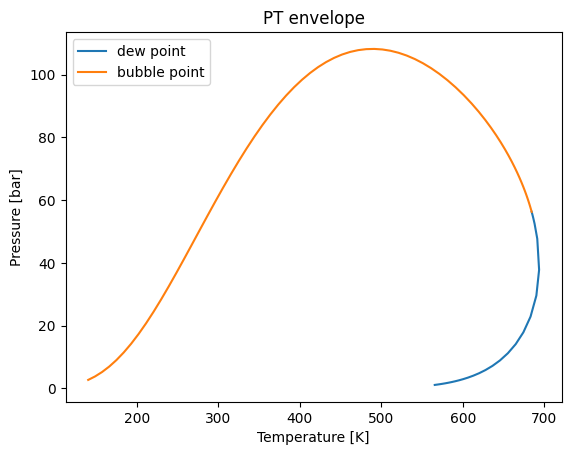

<java object 'neqsim.thermodynamicOperations.ThermodynamicOperations'>

In [ ]:

printFrame(fluid1)
phaseenvelope(fluid1, True)

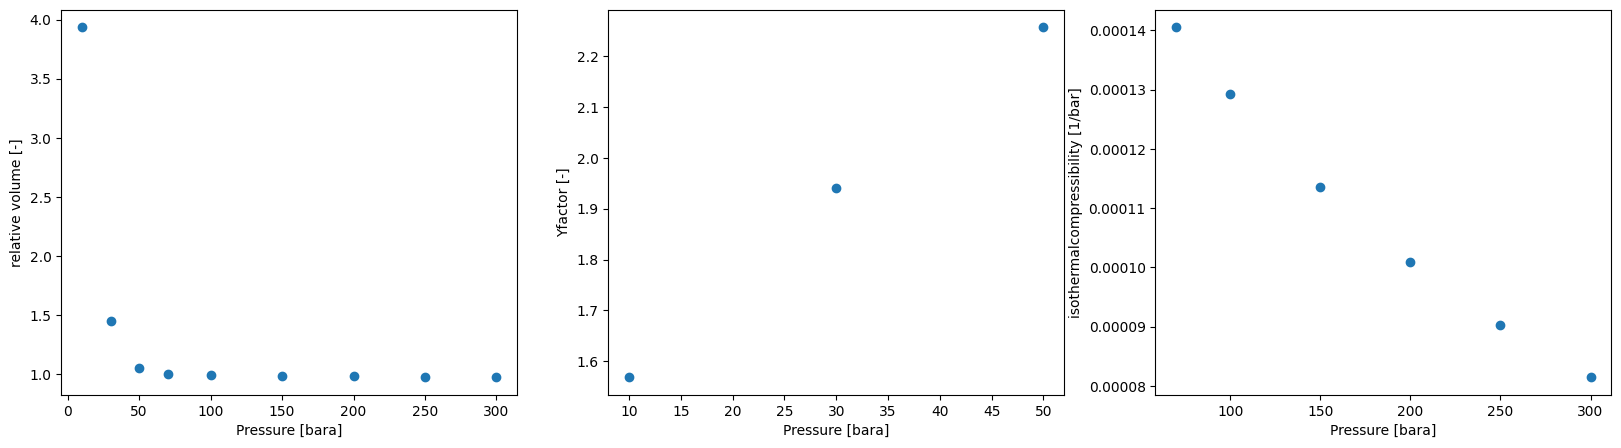

In [ ]:
fluid1 = createfluid('black oil')
resTemperature = 60.0
pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0, 30.0, 10.0]
temperature = [resTemperature]*9

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []
satPressure = None
CME(fluid1,pressure,temperature,satPressure,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()

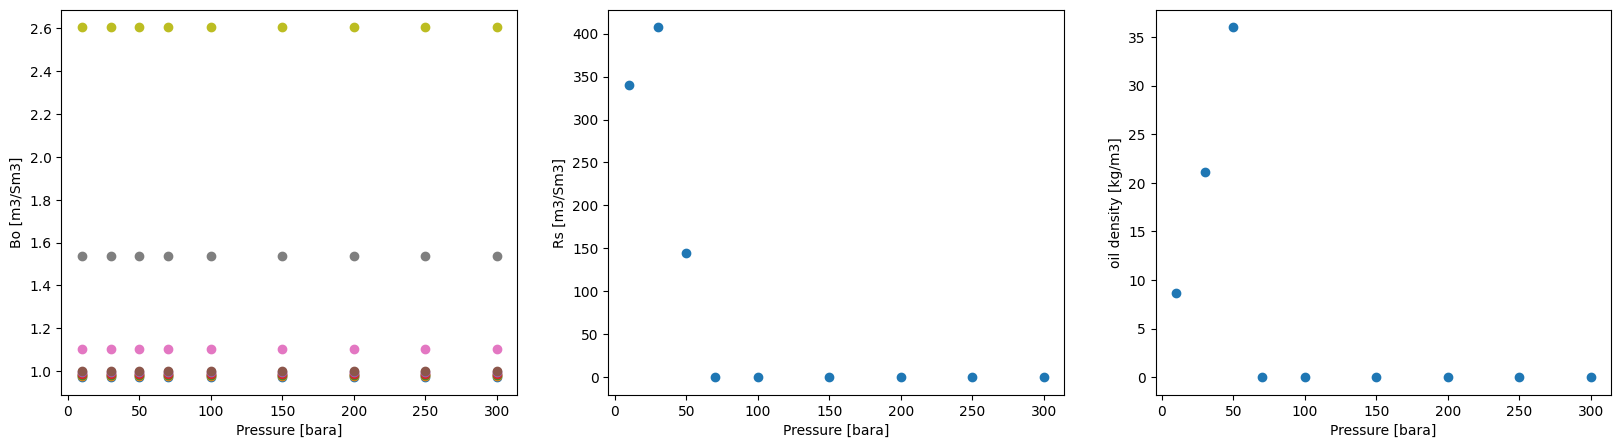

In [ ]:
fluid1 = createfluid('black oil')
pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0, 30.0, 10.0]
temperature = 301.0

Bo = []
Bg = []
relativegravity = []
Zgas =  []
gasstandardvolume = []
Rs = []
oildensity = []
relativegravity = []

difflib(fluid1,pressure,temperature,Bo, Bg,relativegravity,Zgas,gasstandardvolume,Rs, oildensity, relativegravity)


plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, Bo, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Bo [m3/Sm3]')
plt.subplot(132)
plt.plot(pressure, Rs, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Rs [m3/Sm3]')
plt.subplot(133)
plt.plot(pressure, oildensity, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('oil density [kg/m3]')
plt.show()

In [5]:
%%capture
!pip install neqsim

ModuleNotFoundError: No module named 'neqsim.blackoil'